## Get VOC Data
#### pil trick: .convert("P")

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import PIL
from PIL import Image
import numpy as np
from helpers import *
import glob

import pandas as pd

from VOChelpers import *

In [2]:
VOC_PATH = "data/VOC/VOCdevkit/VOC2012/"

In [3]:
# Load all images
image_list = []
image_list_fn = []
for filename in glob.glob(VOC_PATH + 'SegmentationClass/*.png'):
    im=PIL.Image.open(filename)
    image_list.append(im)
    
    # This will only work on windows TODO (to get jpg)
    n = filename.split("\\",1)[1]
    
    # contains image
    image_list_fn.append(n.split(".png",1)[0] + ".jpg")

2007_001825.jpg
[  0   8  12 255]


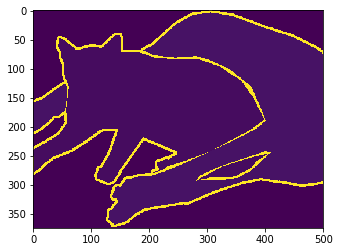

In [4]:
b = np.array(image_list[112].convert(mode="P", palette=Image.ADAPTIVE, colors=21))
print(image_list_fn[112])
print(np.unique(b))
plt.imshow(b)

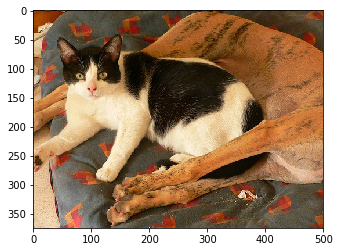

In [5]:
plt.imshow(PIL.Image.open(VOC_PATH + 'JPEGImages/' + image_list_fn[112]))

In [6]:
a = PIL.Image.open(VOC_PATH + 'JPEGImages/' + image_list_fn[112])

In [7]:
nclasses = 21
def imageToMask(img):
    return np.array(img.convert(mode="P", palette=Image.ADAPTIVE, colors=nclasses))

# Returns a (height, width, nclasses) nparray with 1 on pixel where it belongs to one of the 21 classes
def toMultipleArray(PconvertedImage):
    final_ = np.zeros((nclasses, PconvertedImage.shape[0], PconvertedImage.shape[1]))

    for i in range(PconvertedImage.shape[0]):
        for j in range(PconvertedImage.shape[1]):
            pixel_val = PconvertedImage[i,j]
            if pixel_val < nclasses:
                final_[pixel_val, i,j] = 1
            else:
                # Border
                final_[nclasses-1, i,j] = 1
                
    return final_

def softmax2(x):
    mx = np.amax(x,axis=1,keepdims = True)
    x_exp = np.exp(x - mx)
    x_sum = np.sum(x_exp, axis = 1, keepdims = True)
    res = x_exp / x_sum
    return res

from sklearn.utils.extmath import softmax

In [8]:
f = toMultipleArray(b)
f.shape

(21, 375, 500)

In [9]:
len(list_image_sets())

20

In [10]:
import tensorflow as tf
import vgg19

In [11]:
tf.reset_default_graph()
sess = tf.Session()

vgg = vgg19.Vgg19(VGG_PATH + 'vgg19.npy')
vgg_shape = [1, None, None, 3]

images = tf.placeholder("float", vgg_shape, name="images")
vgg.build(images)


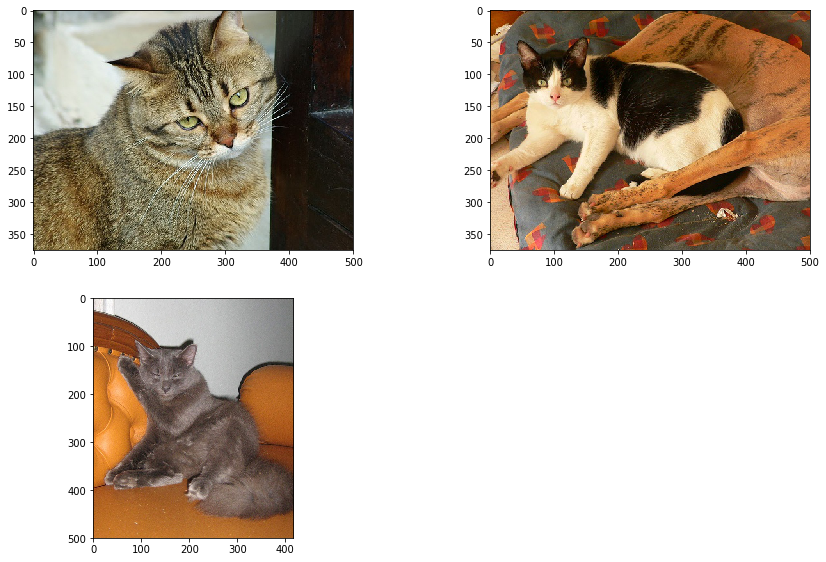

In [56]:
#Image without label
im1 = load_image2(VOC_PATH + "JPEGImages/2007_006641.jpg")

#Image with labelled mask
im2 = load_image2(VOC_PATH + "JPEGImages/2007_001825.jpg")

im3 = load_image2(VOC_PATH + "JPEGImages/2007_002470.jpg")

plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
plt.imshow(im1)
plt.subplot(3,2,2)
plt.imshow(im2)
plt.subplot(3,2,3)
plt.imshow(im3)

In [13]:
# Todo test without activated layers
dict_content = eval_layers(sess, im1, vgg,  ["conv5_4", "conv4_4"])
layer_154 = dict_content.get("conv5_4")
layer_144 = dict_content.get("conv4_4")

dict_content = eval_layers(sess, im2, vgg, ["conv5_4", "conv4_4"])
layer_254 = dict_content.get("conv5_4")
layer_244 = dict_content.get("conv4_4")

dict_content = eval_layers(sess, im3, vgg, ["conv5_4", "conv4_4"])
layer_354 = dict_content.get("conv5_4")
layer_344 = dict_content.get("conv4_4")

In [14]:
layer_154.shape #Upscale this?

(1, 24, 32, 512)

In [123]:
layer_354.shape

(1, 32, 27, 512)

In [15]:
A = compute_affinity_matrix(layer_154, layer_254)
A2 = compute_affinity_matrix(layer_154, layer_354)

In [153]:
A.shape
#Height, Width

(768, 768)

In [154]:
A2.shape

(768, 864)

In [156]:
A3 = np.concatenate([A, A2], axis=1)

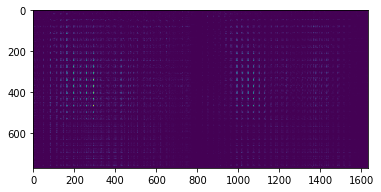

In [160]:
plt.imshow(A3)

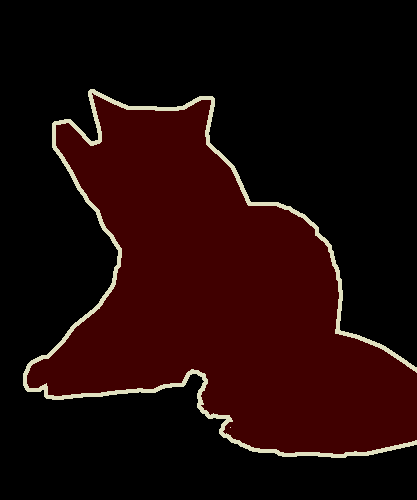

In [105]:
load_voc_mask("2007_002470")

(21, 500, 417)


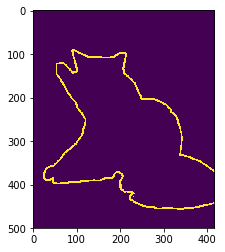

In [170]:
mask2 = toMultipleArray(imageToMask(image_list[112]))
mask = toMultipleArray(imageToMask(load_voc_mask("2007_002470")))
print(mask.shape)

plt.imshow(mask[20])

In [133]:
#resize mask
#maskRz = skimage.transform.resize(mask, (nclasses, layer_154.shape[1], layer_254.shape[2]), mode='constant', order=0)
maskRz = skimage.transform.resize(mask, (nclasses, layer_354.shape[1], layer_354.shape[2]), mode='constant', order=0)
maskRz.shape

(21, 32, 27)

In [134]:
#flatten mask
maskReshape = maskRz.reshape((nclasses, maskRz.shape[1] * maskRz.shape[2]))
maskReshape.shape

(21, 864)

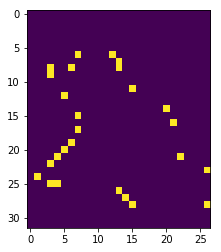

In [139]:
plt.imshow(maskReshape[20].reshape(layer_354.shape[1], layer_354.shape[2]))

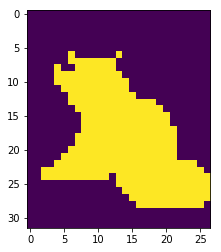

In [140]:
plt.imshow(maskReshape[8].reshape(layer_354.shape[1], layer_354.shape[2]))

In [161]:
W = np.array([softmax(A3[None,i,:]) for i in range(A2.shape[0])])

In [121]:
#WRONG
#W = np.array([softmax(A[None,:,i]) for i in range(A.shape[1])])
W.shape

(768, 1, 864)

In [141]:
W = np.array([softmax(A2[None,i,:]) for i in range(A2.shape[0])])
W.shape

(768, 1, 864)

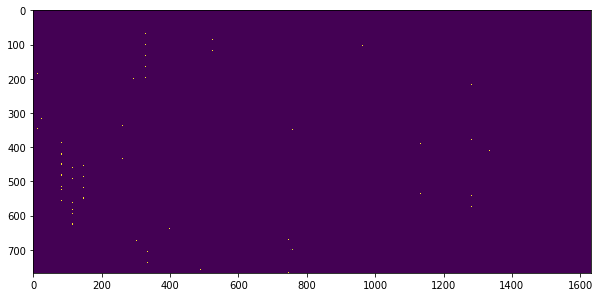

In [168]:
plt.figure(figsize=(10,10))
plt.imshow(W[:,0,:])

In [91]:
??softmax

In [169]:
np.unique(W)

array([  0.00000000e+00,   1.40129846e-45,   2.80259693e-45,
         4.20389539e-45,   9.80908925e-45,   1.12103877e-44,
         1.82168800e-44,   1.96181785e-44,   3.78350585e-44,
         5.74532370e-44,   1.07899982e-43,   1.28919459e-43,
         1.82168800e-43,   1.84971397e-43,   3.06884364e-43,
         3.09686961e-43,   3.67140198e-43,   4.21790838e-43,
         6.12367429e-43,   2.45087101e-42,   6.10966130e-42,
         7.16904294e-42,   1.02827281e-41,   1.15901396e-41,
         2.91273899e-41,   3.07346792e-41,   3.48264707e-41,
         3.77481780e-41,   7.46051302e-41,   8.72098099e-41,
         1.33697886e-40,   1.59197315e-40,   1.67982055e-40,
         2.89044433e-40,   5.45305488e-40,   7.94966428e-40,
         2.37000348e-39,   2.90148516e-39,   3.45233559e-39,
         3.52356078e-39,   4.25267039e-39,   5.40153334e-39,
         2.59935877e-38,   1.00621458e-37,   5.84255095e-37,
         1.20740512e-36,   1.31350875e-36,   1.36183745e-36,
         1.63648504e-36,

In [131]:
W.shape

(768, 1, 864)

In [132]:
maskReshape.shape

(21, 768)

In [135]:
W[1].dot(np.transpose(maskReshape))

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [143]:
W[1].dot(np.transpose(maskReshape))

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [144]:
pred = np.array([W[i].dot(np.transpose(maskReshape)) for i in range(W.shape[0])])

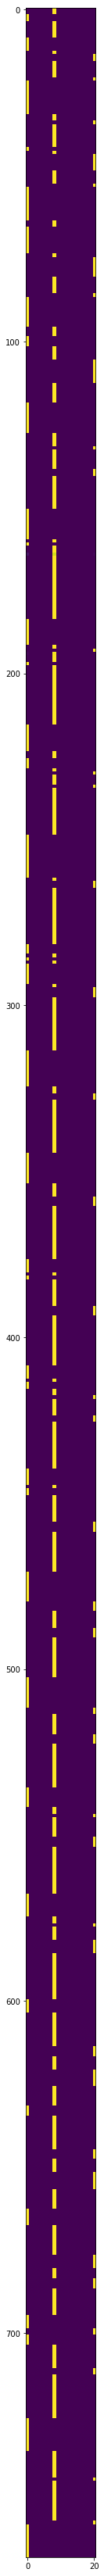

In [145]:
plt.figure(figsize=(2,60))
plt.imshow(pred[:,0,:])

In [148]:
pred_reshape = pred[:,0,:].reshape((layer_154.shape[1], layer_254.shape[2], nclasses ))

In [147]:
pred.shape

(768, 1, 21)

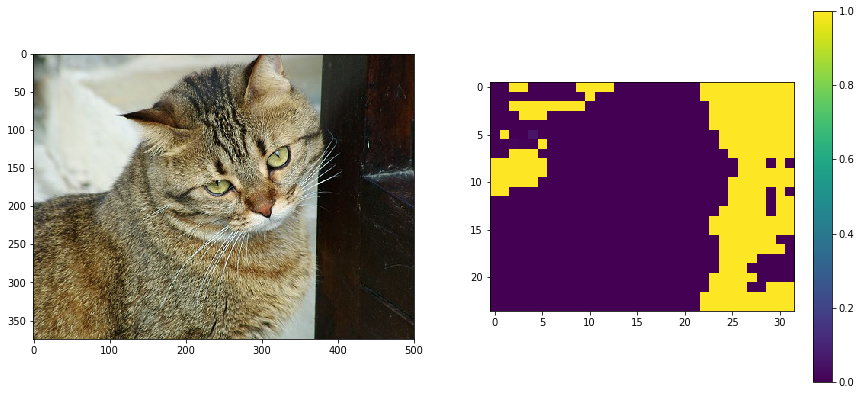

In [149]:
plt.figure(figsize=(15,15));
plt.subplot(2,2,1)
plt.imshow(im1)
plt.subplot(2,2,2)
plt.imshow(pred_reshape[:,:, 0])
plt.colorbar()

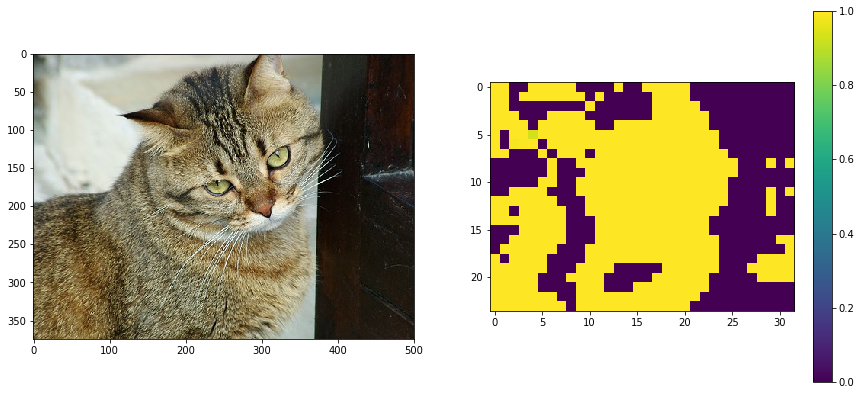

In [150]:
plt.figure(figsize=(15,15));
plt.subplot(2,2,1)
plt.imshow(im1)
plt.subplot(2,2,2)
plt.imshow(pred_reshape[:,:, 8])
plt.colorbar()

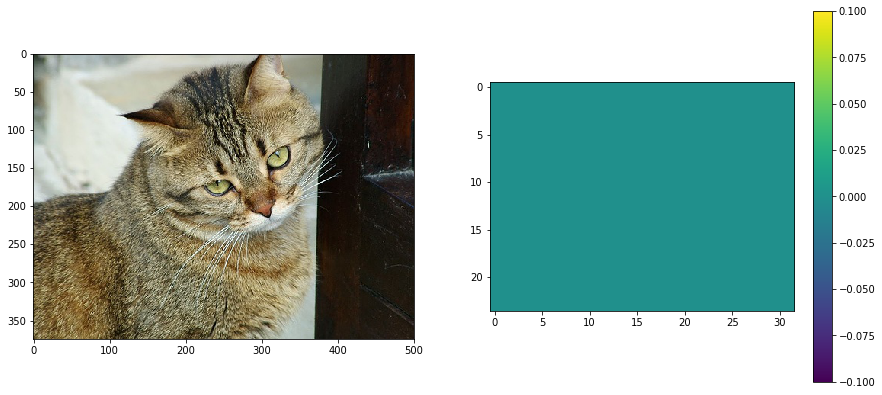

In [151]:
plt.figure(figsize=(15,15));
plt.subplot(2,2,1)
plt.imshow(im1)
plt.subplot(2,2,2)
plt.imshow(pred_reshape[:,:, 12])
plt.colorbar()

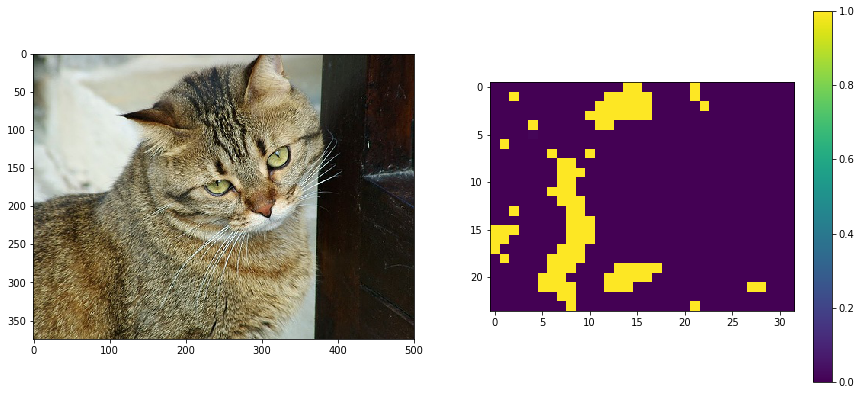

In [152]:
plt.figure(figsize=(15,15));
plt.subplot(2,2,1)
plt.imshow(im1)
plt.subplot(2,2,2)
plt.imshow(pred_reshape[:,:, 20])
plt.colorbar()

In [68]:
df = list_image_segmentation()

In [69]:
df.head()

,0
0,2007_000032
1,2007_000039
2,2007_000063
3,2007_000068
4,2007_000121


In [65]:
df_all = load_data_multilabel("train")

C:\Users\Adan\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\Adan\AppData\Local\conda\conda\envs\tensorflow\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")

  markup_type=markup_type))


In [67]:
df_all

,filename,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,diningtable,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor
0,2008_000008,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,2008_000015,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2008_000019,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


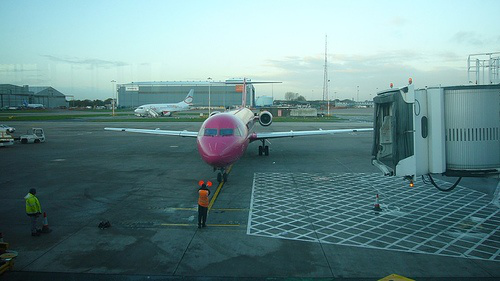

In [90]:
load_img("2007_000032")[0]

In [2]:
from MultipleInstanceLabelling import MIL

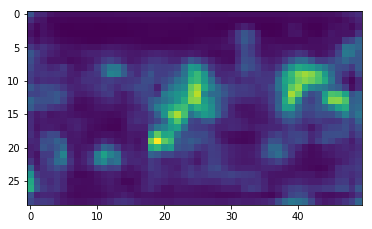

In [22]:
mil = MIL("data/VOC/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg")

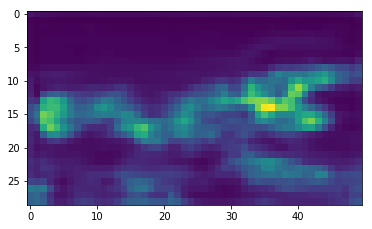

In [25]:
a = mil.performLabelling([ "2007_000032", "2007_002266"])

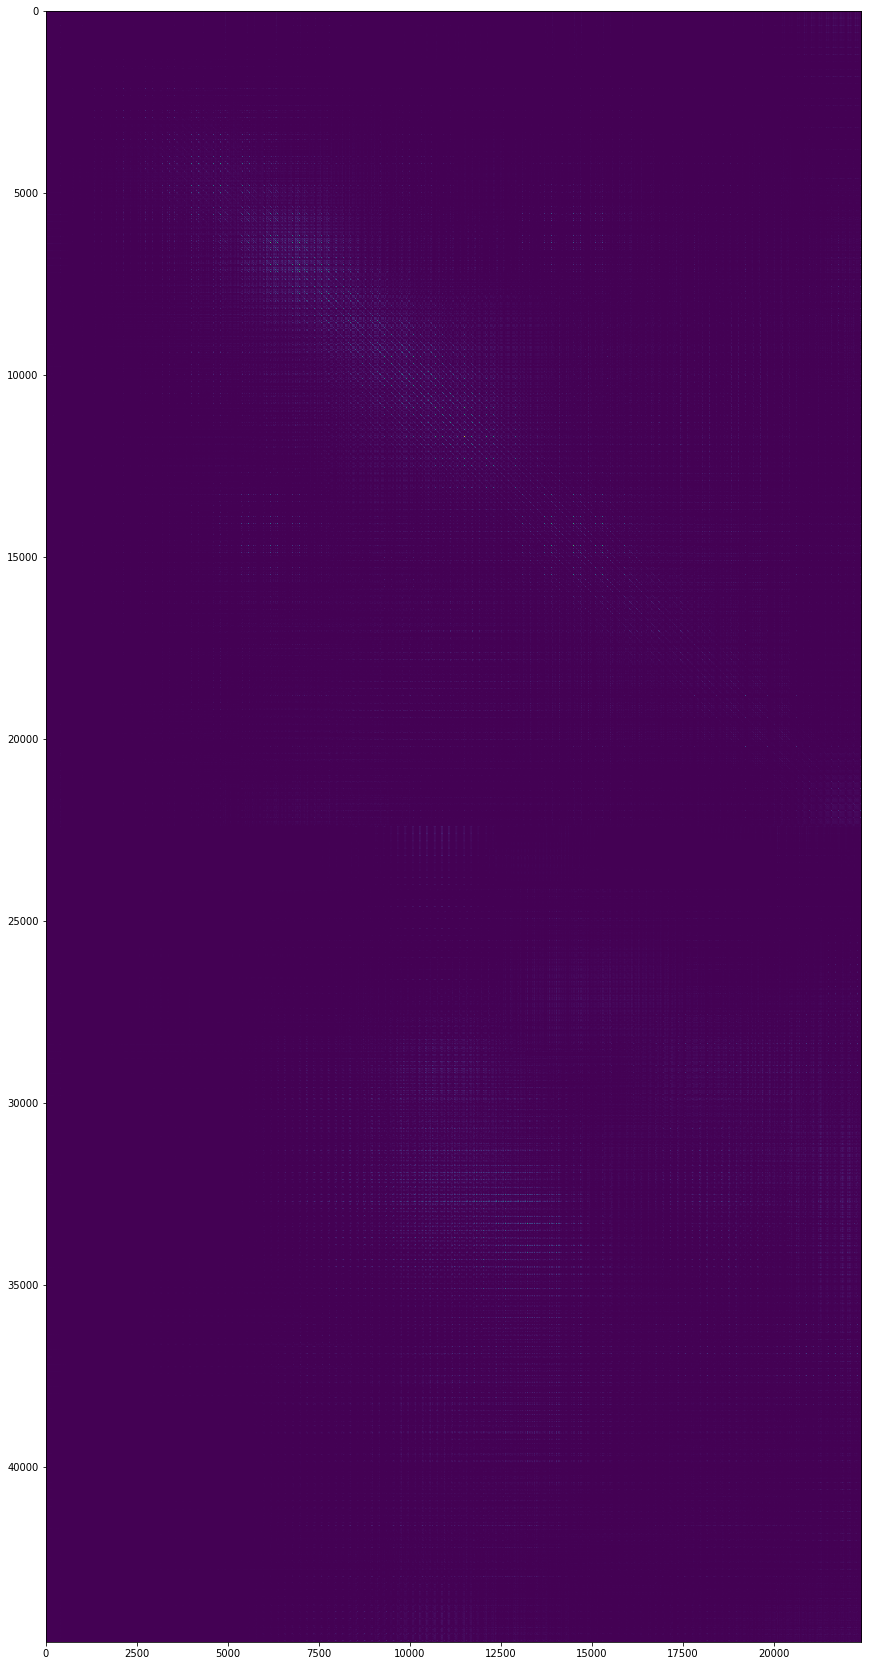

In [27]:
plt.figure(figsize=(15,30))
plt.imshow(a)

In [28]:
a.shape

(44800, 22400)

In [29]:
W = np.array([softmax(a[None, i, :]) for i in range(a.shape[0])])

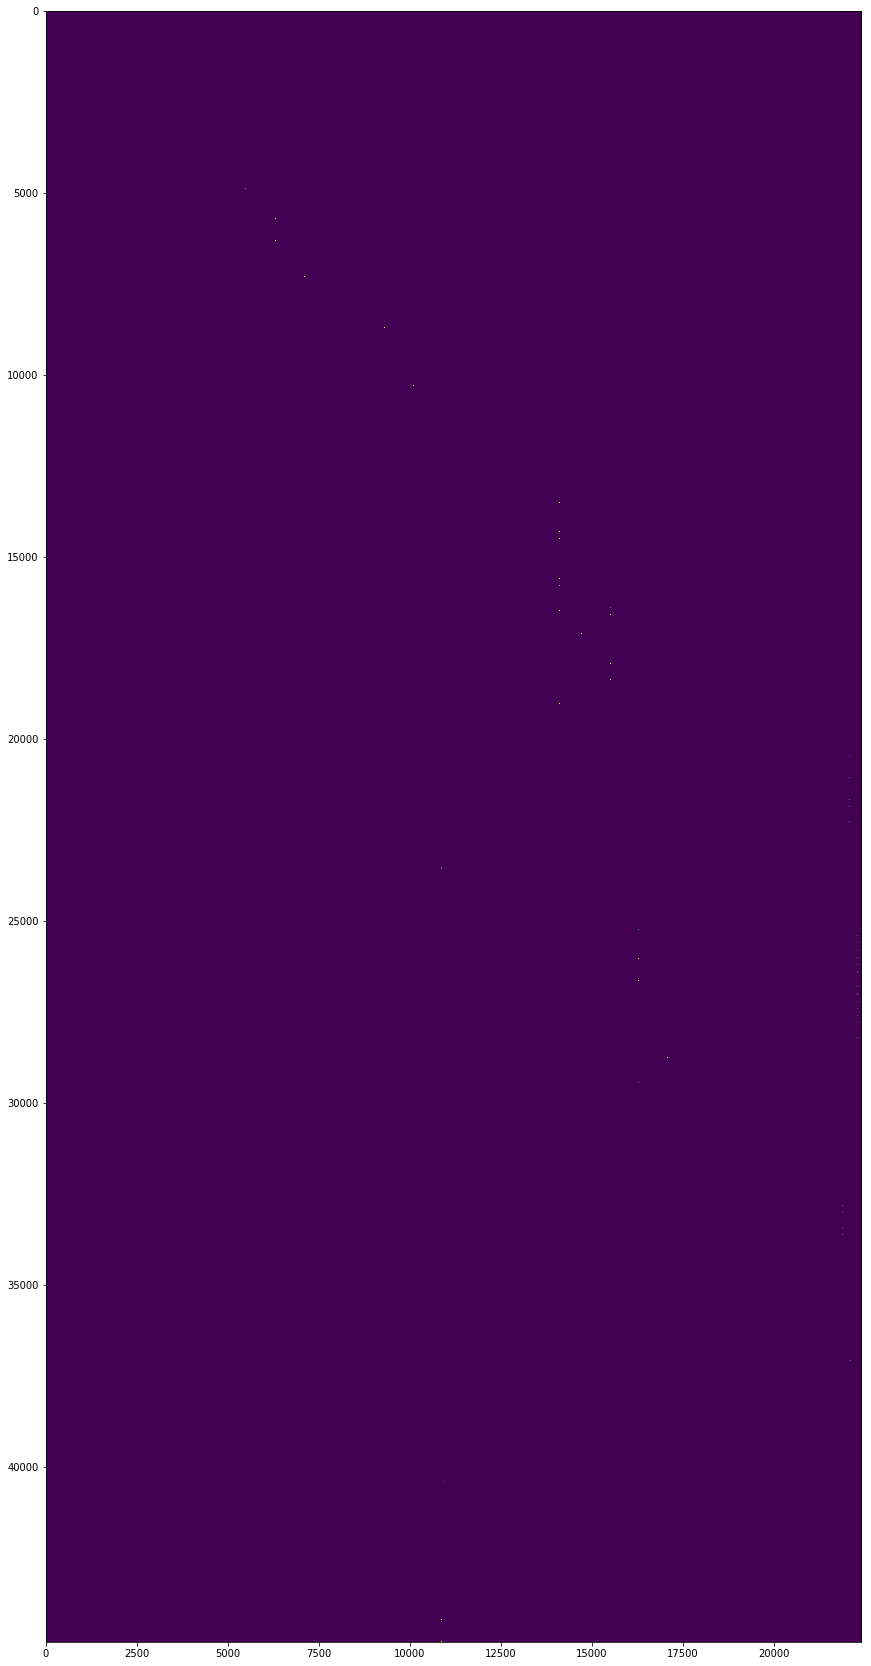

In [30]:
plt.figure(figsize=(20,30))
plt.imshow(W[:,0,:])

mask.shape (21, 19684)
final_aff.shape (19684, 9842)
W.shape (19684, 1, 9842)


ValueError: shapes (1,9842) and (19684,21) not aligned: 9842 (dim 1) != 19684 (dim 0)

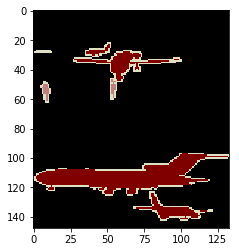

In [6]:
mil = MIL("data/VOC/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg")
a = mil.performLabelling([ "2007_000032", "2007_002266"])

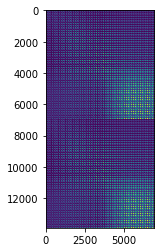

In [7]:
plt.imshow(a)

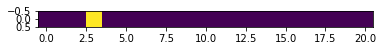

In [47]:
plt.imshow(a)